In [20]:
import tensorflow as tf

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom")
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = 128
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts] # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs) # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)# (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        latent_space = Dense(self.latent_dim, activation="relu")(x)

        # Decoder
        x = Dense(4 * 4 * 32, activation="relu")(latent_space)
        x = Reshape((4, 4, 32))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="valid")(x)
        x = UpSampling2D((2, 2))(x)
        outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        x = inputs
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        x = Dense(self.num_experts, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)

    def get_config(self):  # Ensure `get_config()` includes all constructor args
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "num_clusters": self.num_experts,
        })
        return config

    @classmethod
    def from_config(cls, config):  # Define `from_config()` explicitly
        return cls(**config)


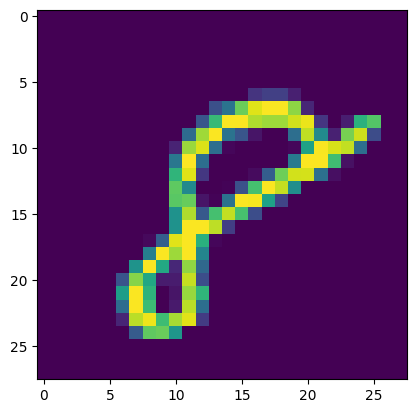

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

plt.imshow(x_train[-1])

In [24]:
filepath = 'moe_1.keras'
model = tf.keras.models.load_model(filepath, custom_objects={"MixtureOfExperts": MixtureOfExperts})

TypeError: <class '__main__.MixtureOfExperts'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'MixtureOfExperts', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'MixtureOfExperts', 'build_config': {'input_shape': [None, 28, 28, 1]}, 'compile_config': {'loss': 'mse', 'loss_weights': None, 'metrics': ['mse'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: MixtureOfExperts.__init__() missing 2 required positional arguments: 'input_dim' and 'num_clusters'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume `model` is your trained MixtureOfExperts instance
# Assume `X_train` is your training data, shape (num_samples, 28, 28, 1)
# Optionally, `y_train` is the true labels, shape (num_samples,)

# Step 1: Compute gating probabilities
gate_output = model.gate.predict(X_train)  # Shape: (num_samples, 2)
p = gate_output[:, 0]  # Probability for Expert 0

# Step 2: Apply t-SNE to reduce dimensionality
X_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (num_samples, 784)
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_flat)  # Shape: (num_samples, 2)

# Step 3: Create the plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=p,                # Color by probability for Expert 0
    cmap='RdBu',        # Diverging color map: blue (low) to red (high)
    vmin=0, vmax=1,     # Probability range
    s=50,               # Point size
    alpha=0.7           # Transparency for overlapping points
)
plt.colorbar(scatter, label='Probability for Expert 0')
plt.title('Gating Network Probability Distribution (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

# Optional: If true labels are available, plot them for comparison
if 'y_train' in locals():
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=y_train,      # Color by true labels
        cmap='tab10',   # Categorical color map
        s=50,
        alpha=0.7
    )
    plt.colorbar(scatter, label='True Label')
    plt.title('True Labels (t-SNE)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.show()

NameError: name 'model' is not defined